- 이미지 인식
    - 시각 피질 작동 원리
        - 시각 인지 과정
            - 계층적으로 발생한다
            - 눈의 앞층에 존재하는 세포들은 이미지의 극히 일부분만 인식(점진적 인식)
            - 뒤로 갈수록 복잡한 세포들은 조금 더 큰 영역의 이미지를 인식
        - 시각의 여러 세포들은 각자 다른 부분을 인지한다
            - 지형학적인 매핑이 발생한다
- 이미지 데이터 → 숫자로 전환 → 컴퓨터는 숫자만 인식
    - 높이, 너비, 채널 → 3차원 텐서로 구성
        - 높이 : 세로 길이의 픽셀 수
        - 너비 : 가로 길이의 픽셀 수
        - 채널 : 색의 성분
            - 흑백 : 채널 수 1 → 0 ~ 255
            - 칼라 : 채널 수 3 → Red, Green, Blue

- python에서 이미지 처리
- Pillow를 사용
- Pillow 이전에는 PIL(Python Image Library)이 패키지를 대체
    - JPEG, BPM, GIF, PNG, PPM, TIFF 등 다양한 포맷 지원
    - PIL 패키지의 대체이므로 이름이 동일

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

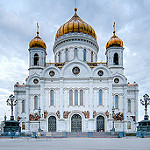

In [2]:
img = Image.open('./data/8.cnn_building.jpg')
img

In [3]:
import numpy as np

In [4]:
np.array(img).shape, type(img), img.size

((150, 150, 3), PIL.JpegImagePlugin.JpegImageFile, (150, 150))

In [5]:
# (150, 150, 1) → 마지막 1(흑백)은 의미가 없어서 삭제
# 흑백 처리
img = img.convert( 'L' )
np.array(img).shape, type(img), img.size

((150, 150), PIL.Image.Image, (150, 150))

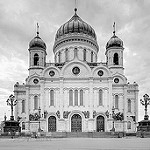

In [6]:
img

In [7]:
import torch

In [8]:
img_tensor = torch.Tensor( np.array(img) )
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [213., 214., 215.,  ..., 196., 197., 198.],
        ...,
        [170., 170., 171.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 172., 174., 167.],
        [168., 168., 168.,  ..., 157., 158., 149.]])

- 합성곱 연산
    <img src = './data/8.합성곱연산_모서리탐지.jpeg'>
- 작은 커널(kernel or filter or 가중치)로 전체 이미지를 처음부터 끝까지 스캔하는 과정
- 5x5x1인 이미지를 3x3 커널(윈도우)로 1x1로 스캔(윈도우 슬라이딩)하면 총 9번 수행된다
    - (5-3+1) * (5-3+1) = 9
    - 이런 스캐닝을 슬라이딩이라고 정의

In [9]:
# 이미지 샘플
ex_img = np.array( [ 
    [ 13, 1, 2, 1, 2 ],
    [ 12, 15, 15, 1, 2 ],
    [ 1, 0, 15, 2, 1 ],
    [ 3, 2, 1, 12, 11 ],
    [ 2, 2, 3, 1, 10 ]
] )
ex_img

array([[13,  1,  2,  1,  2],
       [12, 15, 15,  1,  2],
       [ 1,  0, 15,  2,  1],
       [ 3,  2,  1, 12, 11],
       [ 2,  2,  3,  1, 10]])

In [10]:
ex_img_tensor = torch.Tensor( ex_img )
ex_img_tensor

tensor([[13.,  1.,  2.,  1.,  2.],
        [12., 15., 15.,  1.,  2.],
        [ 1.,  0., 15.,  2.,  1.],
        [ 3.,  2.,  1., 12., 11.],
        [ 2.,  2.,  3.,  1., 10.]])

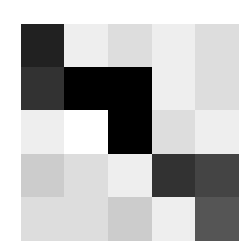

In [11]:
_, ax = plt.subplots(1, 1)
ax.matshow( ex_img, cmap = 'binary' )
ax.axis('off')
plt.show()

In [12]:
# 커널 3x3
kernel = torch.Tensor([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [13]:
# (데이터가 몇 개인가? = 1차원의 성분 수, 2차원의 성분 수)
kernel.size()

torch.Size([3, 3])

In [14]:
# 합성곱 연산 구현
def convolution_operation(x_input, kernel) :
    # x의 크기 획득
    y, x = x_input.size()
    # 커널의 사이즈
    k_y, k_x = kernel.size()
    # 합성곱 연산 결과를 담는 그릇
    convs = []
    for i in range(y-k_y+1) :
        # 구성 요소 중, 같은 자리에 있는 원소끼리 곱해서 모두 더한다
        # c = [ torch.sum( x의 슬라이싱한 값 * 커널 ) for j in range(x-k_x+1) ]
        c = []
        for j in range(x-k_x+1) :
            # 합성곱
            c.append( torch.sum( x_input[ i:i+k_y, j:j+k_x ] * kernel ) )
            # 최대 풀링
            # c.append( torch.max( x_input[ i:i+k_y, j:j+k_x ] * kernel ) )
            # 최소 풀링
            # c.append( torch.min( x_input[ i:i+k_y, j:j+k_x ] * kernel ) )
        convs.append(c)
    # 텐서화
    return torch.Tensor( convs )

In [15]:
convs = convolution_operation( ex_img_tensor, kernel )
convs.size(), np.array( convs )

(torch.Size([3, 3]), array([[ -6.,  12.,  27.],
        [-15.,   2.,  17.],
        [-13., -11.,  -3.]], dtype=float32))

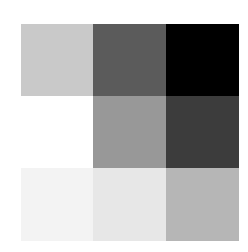

In [16]:
# 이미지가 합성곱층을 통과하여 만들어진 이미지
_, ax = plt.subplots(1, 1)
ax.matshow( convs, cmap = 'binary' )
ax.axis('off')
plt.show()

In [17]:
# 지금 사용한 커널은 수직 커널
# 샘플 이미지에 수직 커널을 적용해 확인
vertical_convs = convolution_operation( img_tensor, kernel )

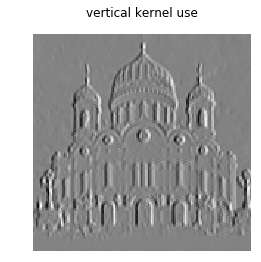

In [18]:
_, ax = plt.subplots(1, 1)
ax.matshow( vertical_convs.numpy(), cmap = 'binary' )
ax.axis('off')
ax.set_title('vertical kernel use')
plt.show()

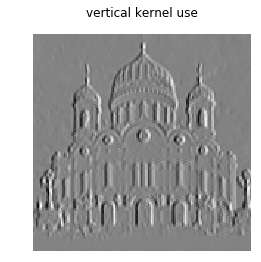

In [19]:
_, ax = plt.subplots(1, 1)
ax.matshow( vertical_convs, cmap = 'binary' )
ax.axis('off')
ax.set_title('vertical kernel use')
plt.show()

In [20]:
# 수평 커널
# t() : 축 회전
horizontal_kernel = kernel.t()

In [21]:
horizontal_convs = convolution_operation( img_tensor, horizontal_kernel )

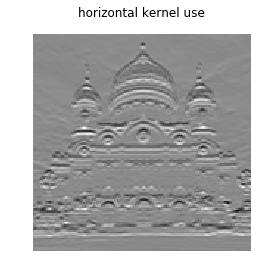

In [22]:
_, ax = plt.subplots(1, 1)
ax.matshow( horizontal_convs.numpy(), cmap = 'binary' )
ax.axis('off')
ax.set_title('horizontal kernel use')
plt.show()

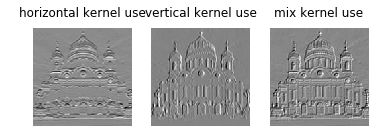

In [23]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.matshow( horizontal_convs.numpy(), cmap = 'binary' )
ax1.axis('off')
ax1.set_title('horizontal kernel use')

ax2.matshow( vertical_convs.numpy(), cmap = 'binary' )
ax2.axis('off')
ax2.set_title('vertical kernel use')

ax3.matshow( (horizontal_convs+vertical_convs).numpy(), cmap = 'binary' )
ax3.axis('off')
ax3.set_title('mix kernel use')

plt.show()

<img src = './data/8.이미지처리.jpeg'>

- 입출력 텐서
    - B : Batch, 배치 크기
    - C : 채널 수(입력채널, 출력채널)
    - H : 이미지의 높이
    - W : 이미지의 너비

In [24]:
import torch
import torch.nn as nn

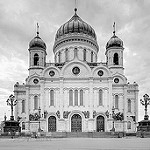

In [25]:
img

In [28]:
img_tmp = np.array(img)
h, w = img_tmp.shape
h, w

(150, 150)

In [31]:
# 배치 파일, 채널 수, 이미지 높이, 이미지 너비
# expand() : 행렬을 확장하는 함수
# 확장한 이유 : API를 사용해서 컴볼루젼을 생성할 것인데, 파라미터가 이런 형태를 원한다 
img_tensor = torch.Tensor( img_tmp ).expand( 1, 1, h, w )  # 2차원 → 4차원
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [32]:
batch, in_channels, height, width = img_tensor.size()

# 출력 채널, 커널 사이즈, 스트라이드 값 설정
out_channels = 1
kernel_size = 3
stride = 1

- 합성곱층 생성 : nn.Conv2d  
in_channels (int) : 입력 채널 수  
out_channels (int) : 출력 채널 수  
kernel_size (int or tuple) : 커널의 크기  
stride (int or tuple, optional) : 윈도우 슬라이딩의 보폭의 크기  
bias (bool, optional) → Default : True  

In [34]:
# pytorch.org
conv_layer = nn.Conv2d( 
    in_channels = in_channels,
    out_channels = out_channels,
    kernel_size = kernel_size,
    stride = stride,
    bias = False
)

In [35]:
conv_layer, type( conv_layer )

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False),
 torch.nn.modules.conv.Conv2d)

In [36]:
# 수직커널
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [37]:
kernel_height, kernel_width = kernel.size()

In [38]:
# 수직커널을 입력 형식과 동일하게 맞추겠다 → 4-Tensor로 확장
conv_layer.weight.data = kernel.expand( 1, 1, kernel_height, kernel_width )

In [41]:
conv_layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [40]:
conv_layer.weight.data.size()

torch.Size([1, 1, 3, 3])

In [43]:
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [42]:
# 합성곱 연산
convs = conv_layer( img_tensor )
convs.size()

torch.Size([1, 1, 148, 148])

- 합성곱층을 통과한 이미지의 W(out), H(out)은
    - H(out) = (H(in) + 2*P - K)/S + 1
        - (150 + 2*0 - 3)/1 + 1 = 148
    - W(out) = (W(in) + 2*P - K)/S + 1
        - (150 + 2*0 - 3)/1 + 1 = 148  
    → 출력 텐서는  
        (B, C, H(out), W(out) → (1, 1, 148, 148)

- K : 커널 크기
- S : 스트라이드(stride)
    - 커널을 이동시키는 보폭

- P : 패딩, padding
    - 이미지의 테두리 주변에 가상의 테두리를 붙인다
    - 통상적으로 패딩은 0
    - 합성곱 연산을 계속 수행하면, 크기가 줄어들어 홀수번째 등 비워 있는 공간이 생기게 되므로, 이를 보정하기 위한 조치
    - 통상적으로 테두리 쪽이 영향을 받는다.
    <img src = './data/8.padding.jpeg' width = '200'>

In [44]:
# torch.Size([1, 1, 148, 148])
convs.size()

torch.Size([1, 1, 148, 148])

In [45]:
# 시각화 하려면 1, 1 차원을 제거
convs.squeeze().size()

torch.Size([148, 148])

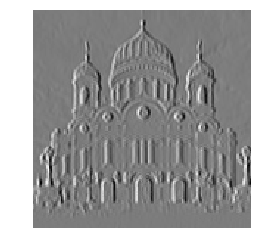

In [46]:
# detach() : 이미지 데이터 추출
# numpy() : 배열화
plt.imshow( convs.squeeze().detach().numpy(), cmap = 'gray' )
plt.axis('off')
plt.show()

In [47]:
# 활성화 함수를 거쳐서 합성곱층을 완성 → relu
activation_maps = torch.relu( convs )
# 경계선이 조금 더 명확해졌다

In [49]:
activation_maps.size()

torch.Size([1, 1, 148, 148])

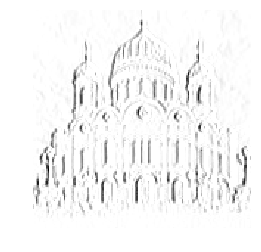

In [51]:
plt.imshow( activation_maps.squeeze().detach().numpy(), cmap = 'binary' )
plt.axis('off')
plt.show()

- 풀링층
    - 활성화된 이미지의 크기를 줄여서 연산 속도를 더 빠르게 가져간다
    - 특징을 유지하면서 활성화맵의 특징을 더 잘 검출할 수 있다
    <img src = './8.pooling.jpeg' width = '300'>

In [52]:
# 커널 사이즈 조정 : 설정
kernel_size = 2
b, c, height, width = activation_maps.size()
b, c, height, width

(1, 1, 148, 148)

In [53]:
# unfold( 차원의 인덱스, 커널 사이즈, 커널 사이즈 )
# 결과로 해당 차원이 줄어들고, 
# 텐서 맨 뒤에 커널 사이즈가 삽입된다
activation_maps.unfold( 2, kernel_size, kernel_size ).size()

torch.Size([1, 1, 74, 148, 2])

In [54]:
activation_maps.unfold( 2, kernel_size, kernel_size ).unfold( 3, kernel_size, kernel_size ).size()

torch.Size([1, 1, 74, 74, 2, 2])

In [56]:
torch.Tensor( [ [1, 2, 3], [4, 5, 6] ] ).max(-1)[0]

tensor([3., 6.])

In [57]:
activation_maps.unfold( 2, kernel_size, 
                       kernel_size ).unfold( 3, kernel_size, 
                                            kernel_size ).max(-1)[0].max(-1)[0].size()

torch.Size([1, 1, 74, 74])

In [61]:
# 직접 구현한다면
def pooling( x, kernel_size, stride=None, type = 'max' ) :
    # 스트라이드를 제시하지 않으면 커널 크기와 동일하게 설정
    if not stride :
        stride = kernel_size
    
    tmp = x.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    if type == 'max' :
        pool = tmp.max(-1)[0].max(-1)[0]
    elif type == 'min' : 
        pool = tmp.min(-1)[0].min(-1)[0]
    elif type == 'mean' :
        pool = tmp.mean(-1)[0].mean(-1)[0]
    else :
        pool = None
    return pool

In [62]:
maxpools = pooling( activation_maps, kernel_size = 2 )
maxpools.size()

torch.Size([1, 1, 74, 74])

In [63]:
# API로 구현
maxpool_layer = nn.MaxPool2d( kernel_size = 2, stride = 2 )
maxpool_layer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [64]:
maxpools = maxpool_layer( activation_maps )
maxpools.size()

torch.Size([1, 1, 74, 74])

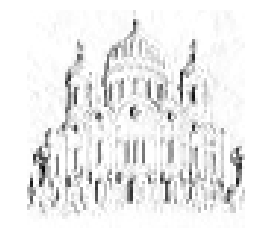

In [65]:
plt.imshow( maxpools.squeeze().detach().numpy(), cmap = 'binary' )
plt.axis('off')
plt.show()